In [1]:

import numpy as np

import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.externals import joblib

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,confusion_matrix, roc_auc_score,roc_curve,auc

from sklearn.pipeline import Pipeline

In [9]:
cd code


/Users/Faliha/Desktop/cap/Medical-Record-Classifier/code


In [10]:
ls

1.LR-TFIDF.pkl                        Pipeline.py
1.LR.pkl.                             Plot.py
2.GB-TFIDF.pkl                        Train.py
2.GB.pkl                              XmlToJson.py
3.GB-TFIDF.pkl                        __pycache__/
3.GB.pkl                              demo.xml
Helper.py                             smokers_surrogate_all_data copy.json
Pipeline copy.py


# Data Preprocessing

In [11]:
#converted xml to json
df0 = pd.read_json('smokers_surrogate_all_data copy.json')

In [12]:
df=df0.copy()

In [13]:
#Transposing to rearrange columns
df=df.T

In [14]:
df=df.reset_index()

In [15]:
#giving columns names
df.columns = ['id', 'smoking_status','descrp']

In [16]:
df.smoking_status.value_counts()

UNKNOWN           315
NON-SMOKER         82
PAST SMOKER        47
CURRENT SMOKER     46
SMOKER             12
Name: smoking_status, dtype: int64

In [17]:
#merging smoker with current smoker category since smoker category has very few records
df['smoking_status']=df['smoking_status'].replace({'SMOKER': 'CURRENT SMOKER'})

# EDA

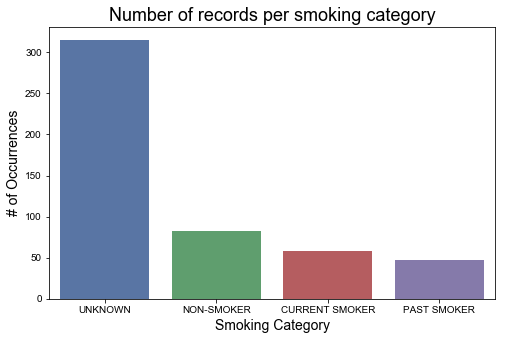

In [18]:
def CategoryCounts(df,column):
    a4_dims = (8, 5)

    fig, ax = plt.subplots(figsize=a4_dims)
    sns.set(style="darkgrid")
    mx=df[column].sort_values()
    sns.countplot(mx, data=df,order = df[column].value_counts().index)
    plt.title("Number of records per smoking category", fontsize=18)
    plt.ylabel('# of Occurrences', fontsize=14)
    plt.xlabel('Smoking Category', fontsize=14)
    plt.show()
    
CategoryCounts(df,'smoking_status')


In [19]:
#new value counts after the merge

df.smoking_status.value_counts()

UNKNOWN           315
NON-SMOKER         82
CURRENT SMOKER     58
PAST SMOKER        47
Name: smoking_status, dtype: int64

### Stop Words

In [20]:
# added own stop words along with the standard list
sw=['summaryunsigneddisreport','amed','date','patient','mm', 'st','amdischarge','doctor', 'hospital',
    'surgery','pain','problem','discharge','admission','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
    'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am','be',
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'of', 'at', 'by', 'for', 'about', 'against', 
    'between', 'into', 'through', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'further', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'more', 
    'most', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'just', 'don', "don't",
    'should', "should've", 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'ma', 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'won', "won't", 'wouldn', "wouldn't"
    'aboard','about','above','across','along','an','and','another','any','around','as','at','below','behind','below'
    ,'beneath','beside','beyond','certain','down','during','each','following','for','from','inside','into','its',
    'like','minus','my','near','next','opposite','outside','out','over','plus','round','so','some','than','through',
    'toward','underneath','unlike','yet','under','unsigneded','yregistration']


### Text processing

In [21]:
 def text_process(description):
        # remove punctuations
    nopunc=[char for char in description if char not in string.punctuation]
    nopunc=''.join(nopunc)
    # remove numbers from the words
    splitnum  = re.split('(\d+)',nopunc)
    splitnum=' '.join(splitnum)
    # remove numbers within the words
    new=re.sub(" \d+", " ", splitnum)
    
    # remove the stop words 
    swtext= [word.lower() for word in new.split() if word not in [x.upper() for x in sw]]
    text=' '.join(swtext)
    return text

# use apply function to apply to the whole df

### Correlated uni and bi grams

In [44]:
#changing status into number categories 
df['smoking_cat'] = df['smoking_status'].factorize()[0]
category_id_df = df[['smoking_status', 'smoking_cat']].drop_duplicates().sort_values('smoking_cat')
category_to_id = dict(category_id_df.values)

In [45]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        preprocessor=text_process,stop_words=sw, max_df=0.8)
features = tfidf.fit_transform(df.descrp).toarray()
labels = df.smoking_cat
features.shape

(502, 26970)

In [46]:

N = 3
for smoking_status, smoking_cat in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == smoking_cat)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(smoking_status))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print('---------------------------')
    
    

# 'CURRENT SMOKER':
  . Most correlated unigrams:
. smoker
. smokes
. smoking
  . Most correlated bigrams:
. smoking cessation
. pm scheduled
. smoking history
---------------------------
# 'NON-SMOKER':
  . Most correlated unigrams:
. naeelv
. tobacco
. smoke
  . Most correlated bigrams:
. denies tobacco
. history denies
. not smoke
---------------------------
# 'PAST SMOKER':
  . Most correlated unigrams:
. smoked
. painless
. quit
  . Most correlated bigrams:
. per history
. painless jaundice
. history quit
---------------------------
# 'UNKNOWN':
  . Most correlated unigrams:
. preliminary
. information
. smoking
  . Most correlated bigrams:
. please call
. pcp name
. social history
---------------------------


# Classification -Level 1

In [28]:
# seperating records based on unknown and known smoking related text status
def unknown(column):
    if 'UNKNOWN' in column :
        return 1

    else: return 0

df["smoking_unknown"] = df["smoking_status"].apply(unknown)

In [29]:
df.smoking_unknown.value_counts()

1    315
0    187
Name: smoking_unknown, dtype: int64

## Modeling

In [30]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_label):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # get the predicted probabilty of one class 
    prob=classifier.predict_proba(feature_vector_test)
    pred=prob[:,1]
    
    # output the results
    print ("{} ".format(classifier))
    print ('Accuracy:',accuracy_score(predictions, test_label))
    print ('Recall:',recall_score(predictions, test_label),)
    print ('Precision:',precision_score(predictions, test_label))
    print ('F1:',f1_score(predictions, test_label))
    print ('ROC:',roc_auc_score(test_label,pred))
    print ('CM:',confusion_matrix(predictions, test_label))
    
    
    return classifier,accuracy_score(predictions, test_label), recall_score(predictions, test_label),precision_score(predictions, test_label), f1_score(predictions, test_label),roc_auc_score(test_label,pred), confusion_matrix(predictions, test_label),pred



In [31]:
def plot_confusion_matrix(cm):
    print(cm)

    # Show confusion matrix in a separate window
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d',xticklabels=['Known','Unknown'],yticklabels=['Known','Unknown'])
    plt.title('Confusion matrix')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
X  = df['descrp']
y = df['smoking_unknown']

In [33]:
X_train,  X_test,  y_train, y_test  =  train_test_split(X,y,test_size=0.25, random_state=42)

#### Random Forest

In [30]:
# Tfidf vec for RF

tfidf_vect = TfidfVectorizer(use_idf= False,norm= 'l2',preprocessor=text_process,ngram_range= (1, 3),
                             min_df= 5,max_features= 2000,max_df=0.9)


tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)


In [31]:
len(tfidf_vect.vocabulary_)

2000

In [32]:
rf,accuracy_rf, recall_rf, precision_rf, f1_rf,roc_rf, cm_rf,pred_rf = train_model(RandomForestClassifier
                                            (n_estimators= 266,min_samples_split=5,min_samples_leaf= 1,
                                             random_state=1,max_features =0.2,max_depth= 50), 
                                                                        xtrain_tfidf, y_train, xtest_tfidf,y_test)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=266, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False) 
Accuracy: 0.9047619047619048
Recall: 0.9540229885057471
Precision: 0.9120879120879121
F1: 0.9325842696629213
ROC: 0.9544740973312402
CM: [[31  8]
 [ 4 83]]


[[31  8]
 [ 4 83]]


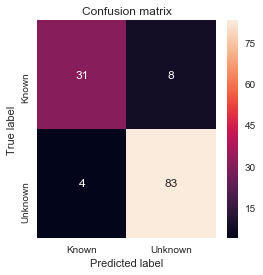

In [33]:
plot_confusion_matrix(cm_rf)

#### Naive Bayes

In [34]:
# Tfidf vec for NB

tfidf_vect = TfidfVectorizer(use_idf= True,norm= 'l2',preprocessor=text_process,ngram_range= (1, 2),
                             min_df= 2,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [35]:
nb,accuracy_nb, recall_nb, precision_nb, f1_nb,roc_nb,cm_nb,pred_nb = train_model(MultinomialNB(alpha=0.1),
                                                                       xtrain_tfidf, y_train, xtest_tfidf,y_test)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True) 
Accuracy: 0.7222222222222222
Recall: 0.9117647058823529
Precision: 0.6813186813186813
F1: 0.7798742138364779
ROC: 0.8178963893249607
CM: [[29 29]
 [ 6 62]]


[[29 29]
 [ 6 62]]


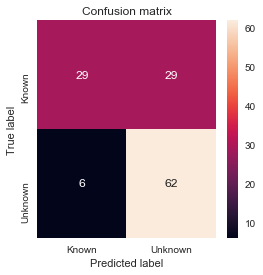

In [36]:
plot_confusion_matrix(cm_nb)

#### Logistic Regression

In [47]:
# Tfidf vec for LR
tfidf_vect = TfidfVectorizer(use_idf= True,sublinear_tf= True,norm= 'l2',preprocessor=text_process,
                             ngram_range= (1, 3),min_df= 4,max_features=3000,max_df=0.9)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)


In [48]:
lr,accuracy_lr, recall_lr, precision_lr, f1_lr,roc_lr,cm_lr,pred_lr=train_model(LogisticRegression(random_state=15325,penalty='l1',C=1000),xtrain_tfidf, y_train, xtest_tfidf,y_test)



LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=15325, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
Accuracy: 0.9365079365079365
Recall: 0.9770114942528736
Precision: 0.9340659340659341
F1: 0.9550561797752809
ROC: 0.9821036106750392
CM: [[33  6]
 [ 2 85]]


[[33  6]
 [ 2 85]]


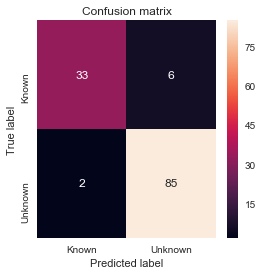

In [39]:
plot_confusion_matrix(cm_lr)

#### Gradient Boosting

In [40]:
# Tfidf vec for GB
tfidf_vect = TfidfVectorizer(use_idf= False,sublinear_tf= True,norm= 'l1',preprocessor=text_process,
                             ngram_range= (1, 2),min_df= 3,max_features=7000,max_df=0.8)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)


In [41]:
gb,accuracy_gb, recall_gb, precision_gb, f1_gb,roc_gb,cm_gb,pred_gb=train_model(GradientBoostingClassifier(min_samples_leaf= 1,
                                 min_samples_split= 20,max_features= 'auto',max_depth=1, learning_rate= 0.05,n_estimators=100,random_state=15325),
            xtrain_tfidf, y_train, xtest_tfidf,y_test)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=1,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=20,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=15325, subsample=1.0, verbose=0,
              warm_start=False) 
Accuracy: 0.9523809523809523
Recall: 0.956989247311828
Precision: 0.978021978021978
F1: 0.967391304347826
ROC: 0.9819466248037676
CM: [[31  2]
 [ 4 89]]


[[31  2]
 [ 4 89]]


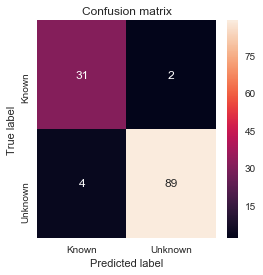

In [42]:
plot_confusion_matrix(cm_gb)

#### ROC CURVE

<Figure size 432x288 with 0 Axes>

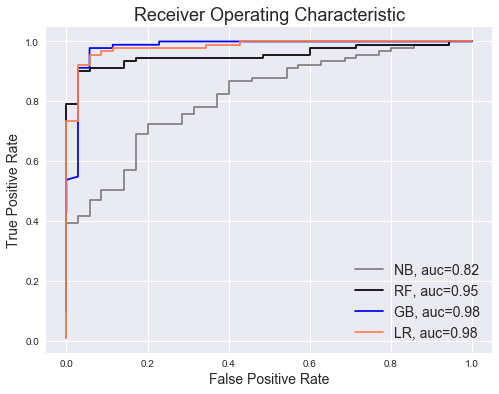

In [43]:
plt.figure(0).clf()
fig, ax = plt.subplots(figsize=(8,6))
plt.title('Receiver Operating Characteristic',fontsize=18)
#ax.set_facecolor('lightpink')


fpr, tpr, thresh = roc_curve(y_test, pred_nb)
auc = roc_auc_score(y_test, pred_nb)
plt.plot(fpr,tpr,'gray',label="NB, auc="+str(round(auc, 2)))



fpr, tpr, thresh = roc_curve(y_test, pred_rf)
auc = roc_auc_score(y_test, pred_rf)
plt.plot(fpr,tpr,'black',label="RF, auc="+str(round(auc, 2)))



fpr, tpr, thresh = roc_curve(y_test, pred_gb)
auc = roc_auc_score(y_test, pred_gb)
plt.plot(fpr,tpr,'blue',label="GB, auc="+str(round(auc, 2)))

fpr, tpr, thresh = roc_curve(y_test, pred_lr)
auc = roc_auc_score(y_test, pred_lr)
plt.plot(fpr,tpr,'coral',label="LR, auc="+str(round(auc, 2)))


plt.legend(loc = 'lower right',fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)

plt.show()
fig.savefig('layer1roc.jpg')


Different models were optimised using random search. Hence each model had a different tfidf vector which help tune the hyper parameters.